In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data
import statsmodels.api as sm
import datetime as dt

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Campaign Money & Electoral Victory

Questions we want to answer: 
* what type of financial contributions do candidates rely on?
* which candidates received the most contributions? from which party/state were they?
* do higher expenditures increase a candidate's chance of success? 

### Data Overview

The dataset comes from Kaggle. It contains financial information for the 2015-2016 electoral year from candidates to the U.S. House and Senate, as well as information about the outcome of the election (whether the candidate won).

In [130]:
candidate_money_OG = pd.read_csv(r"CandidateS.csv")
money = candidate_money_OG

In [131]:
money.head()

,can_id,can_nam,can_off,can_off_sta,can_off_dis,can_par_aff,can_inc_cha_ope_sea,can_str1,can_str2,can_cit,...,cas_on_han_beg_of_per,cas_on_han_clo_of_per,net_con,net_ope_exp,deb_owe_by_com,deb_owe_to_com,cov_sta_dat,cov_end_dat,winner,votes
0,H2GA12121,"ALLEN, RICHARD W",H,GA,12.0,REP,INCUMBENT,2237 PICKENS RD,NaN,AUGUSTA,...,"$60,109.57","$175,613.35","$1,074,949.50","$907,156.21","$1,125,000.00",NaN,1/1/2015,10/19/2016,Y,158708.0
1,H6PA02171,"EVANS, DWIGHT",H,PA,2.0,DEM,CHALLENGER,PO BOX 6578,NaN,PHILADELPHIA,...,NaN,"$105,687.23","$1,406,719.06","$1,298,831.83",NaN,NaN,11/2/2015,10/19/2016,Y,310770.0
2,H6FL04105,"RUTHERFORD, JOHN",H,FL,4.0,REP,OPEN,3817 VICKERS LAKE DRIVE,NaN,JACKSONVILLE,...,NaN,"$35,645.09","$650,855.38","$656,210.29","$60,000.00",NaN,4/1/2016,10/19/2016,Y,286018.0
3,H4MT01041,"ZINKE, RYAN K",H,MT,0.0,REP,INCUMBENT,409 2ND ST W,NaN,WHITEFISH,...,"$83,815.78","$399,122.61","$4,938,943.74","$5,055,942.15",NaN,NaN,1/1/2015,10/19/2016,Y,280476.0
4,H8CA09060,"LEE, BARBARA",H,CA,13.0,DEM,INCUMBENT,"409 13TH ST, 17TH FL",NaN,OAKLAND,...,"$83,690.60","$181,338.23","$1,197,676.61","$949,488.98","$4,401.75",NaN,1/1/2015,10/19/2016,Y,277390.0


In [132]:
money.shape

(1814, 51)

Having successfully loaded in the datafile, the first step is going to be to clean it and narrow it down to our categories of interest.

We exclude `'can_str1', 'can_str2', 'can_cit', 'can_sta', 'can_zip'` (the candidate's address) and `'net_con', 'net_ope_exp'` (net expenditures). A number of categories (e.g. `'off_to_ope_exp', 'tra_to_oth_aut_com', 'can_loa_rep', 'oth_loa_rep', 'deb_owe_by_com', 'deb_owe_to_com', 'ind_ref', 'par_com_ref','oth_com_ref'`) are not particularly interesting for our purposes so are also excluded. Finally, `off_to_fun, off_to_leg_acc, exe_leg_acc_dis, fun_dis` are all only valid for Presidential candidates and are removed.

In [133]:
money = money[['can_id', 'can_nam', 'can_off', 'can_off_sta', 'can_off_dis',
       'can_par_aff', 'can_inc_cha_ope_sea', 'ind_ite_con', 'ind_uni_con', 'ind_con',
       'par_com_con', 'oth_com_con', 'can_con', 'tot_con', 'tot_loa', 'oth_rec', 
        'tot_rec', 'ope_exp', 'tot_dis', 'cas_on_han_beg_of_per', 'cas_on_han_clo_of_per', 
        'net_con', 'net_ope_exp', 'cov_sta_dat', 'cov_end_dat', 'winner']]

The remaining categories are the following: 
* `can_id`: Candidate ID
* `can_nam`: Candidate Name
* `can_off`: Candidate Office (P=President, S=Senate, H= House)
* `can_off_sta` : Candidate Office State
* `can_off_dis` : Candidate Office District	Number	(for House candidates)
* `can_par_aff` : Candidate Party Affiliation (Dem=Democrat, Rep=Republican)
* `can_inc_cha_ope_sea` :	Candidate Incumbent Challenger Open Seat (I=incumbent, C=challenger, O=open seat)
* `ind_ite_con` : Individual Itemized Contribution	(Sum of itemized contributions from individuals, contribution > 200)
* `ind_uni_con` : Individual Unitemized Contribution (Sum of unitemized contributions from individuals, contribution <= 200)
* `ind_con` : Individual Contribution (Total contributions from individuals) (Sum of `ind_ite_con` and `ind_uni_con`)
* `par_com_con` : Party Committee Contribution
* `oth_com_con` : Other Committee Contribution (Contributions from other committee, mostly PACs)
* `can_con` : Candidate Contribution (Contributions from the candidate him(her)self)
* `tot_con` : Total Contribution (Sum of `ind_con`, `par_com_con`, `oth_com_con` and `can_con`)
* `tot_loa` : Total Loan
* `oth_rec` : Other Receipts (e.g. interest on bank deposits, capital gains, etc.)
* `tot_rec` : Total Receipts (Sum of all receipt categories)
* `ope_exp` : Operating Expenditure   
* `tot_dis` : Total Disbursement
* `cas_on_han_beg_of_per` : Cash on Hand Beginning of Period
* `cas_on_han_clo_of_per` : Cash on Hand Close of Period 
* `net_con` : Net Contribution	(Sum of all contributions minus any contribution refunds)
* `net_ope_exp`: Net Operating Expenditure (Sum of all operating expenditures minus any offsets to those expenditures)
* `cov_sta_dat` : Coverage Start Date	
* `cov_end_dat`: Coverage End Date
* `winner` : Whether the candidate won (Y if so, NaN otherwise)

In [134]:
money.dtypes.head(10)

can_id                  object
can_nam                 object
can_off                 object
can_off_sta             object
can_off_dis            float64
can_par_aff             object
can_inc_cha_ope_sea     object
ind_ite_con             object
ind_uni_con             object
ind_con                 object
dtype: object

There is a big problem with this dataset: most of the expenditure columns aren't in a numerical format, because of formatting errors. These include: adding a dollar sign before the amount, using `,` for thousands, using `()` for (presumably) negative accounts. The process of finding all columns with dollar signs and transforming them into floats is automated below.

The first step is to find strings with dollar signs: `str.find()` equals zero when there is a match and -1 when there isn't. The code below loops through every 'string' column of the dataframe, then every element of every column, to find a dollar sign. If the majority of the elements have a dollar sign in them, the code loops through, removing punctuation signs as appropriate, and reclassifies the resulting object as a float. (Note: ( is replaced by - because elements in parenthesis are usually coded as negative in accounting).

In [135]:
for i in money.columns:
    if money[i].dtype == object:
        if (money[i].str.find("$").mean() < 0.1) == True and (money[i].str.find("$").mean() > -0.1) == True:
            money[i] = money[i].str.replace("$","").str.replace(",","").str.replace("(","-").str.replace(")","").astype(float)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [136]:
money.dtypes.head(10)

can_id                  object
can_nam                 object
can_off                 object
can_off_sta             object
can_off_dis            float64
can_par_aff             object
can_inc_cha_ope_sea     object
ind_ite_con            float64
ind_uni_con            float64
ind_con                float64
dtype: object

We also change NaNs into zero so we can more easily compute summary stats etc.

In [137]:
money = money.fillna(value= 0)

We'll be using `can_inc_cha_ope_sea` quite a bit later, so rows that have NaNs in that specific column are dropped.

In [138]:
money = money[money["can_inc_cha_ope_sea"] != 0]

The code successfully reformated all of our expenditure columns. Now, we need to change  `'cov_sta_dat', 'cov_end_dat'` into datetime objects.

In [139]:
money["cov_sta_dat"] = pd.to_datetime(money["cov_sta_dat"], format = "%m/%d/%Y")
money["cov_end_dat"] = pd.to_datetime(money["cov_end_dat"], format = "%m/%d/%Y")

In [140]:
money["length"] = money["cov_end_dat"] - money["cov_sta_dat"]

We perform a quick sanity check:

In [141]:
money["length"].min()

Timedelta('-940 days +00:00:00')

This shouldn't be happening. Only one observation has a negative campaign duration, but it's still worth excluding it.

In [142]:
money = money[money["length"] > dt.timedelta(days = 1)]

The final problem is that `can_par_aff` includes **a lot** of party affiliations. Democrats and Republicans are by far the main political parties in the U.S. We'll group all the other parties under "independent" for simplicity.

In [143]:
money.groupby("can_par_aff")["par_com_con"].count().head()

can_par_aff
0        1
AMP      1
CON      4
CST      1
DEM    712
Name: par_com_con, dtype: int64

In [144]:
new_party = []

for i in money["can_par_aff"]:
    if i == "DEM":
        new_party.append("DEM")
    elif i == "REP":
        new_party.append("REP")
    else:
        new_party.append("IND")

money["party"] = new_party

In [145]:
money.groupby("party")["par_com_con"].count().head()

party
DEM    712
IND    218
REP    881
Name: par_com_con, dtype: int64

We also create a new column that codes 'wins' as a 0,1 dummy (1 = win, 0 = lost). Coding it as a dummy will make it easier for us to run a regression later on.

In [146]:
win = []

for i in money["winner"]:
    if i == "Y":
        win.append(1)
    else:
        win.append(0)

money["winner"] = win

The last step is to convert our contributions types into percentages of total contributions. This will allow us to quickly compare the contribution structure for different types of candidates.

In [147]:
for i in ["ind_con", "can_con", "par_com_con", "oth_com_con"]:
    newcol = i + "_per"
    money[newcol] = money[i] / money["tot_con"]

We end by looking at our dataset once again. It looks ready to work with. 

In [148]:
money.shape

(1811, 32)

In [149]:
money[100:105]

,can_id,can_nam,can_off,can_off_sta,can_off_dis,can_par_aff,can_inc_cha_ope_sea,ind_ite_con,ind_uni_con,ind_con,...,net_ope_exp,cov_sta_dat,cov_end_dat,winner,length,party,ind_con_per,can_con_per,par_com_con_per,oth_com_con_per
100,H2FL14053,"FRANKEL, LOIS J.",H,FL,21.0,DEM,INCUMBENT,941846.23,101331.06,1043177.29,...,506462.37,2015-01-01,2016-10-19,1,657 days,DEM,0.658830,0.0,0.000014,0.341156
101,H0CT03072,"DELARUO, ROSA L",H,CT,3.0,DEM,INCUMBENT,454564.68,44839.24,499403.92,...,538356.49,2015-01-01,2016-10-19,1,657 days,DEM,0.483123,0.0,0.000000,0.516877
102,H8ID02064,"SIMPSON, MICHAEL",H,ID,2.0,REP,INCUMBENT,241109.61,22506.99,263616.60,...,506848.06,2015-01-01,2016-10-19,1,657 days,REP,0.270386,0.0,0.000000,0.729614
103,H4LA05221,"ABRAHAM, RALPH LEE DR. JR.",H,LA,5.0,REP,INCUMBENT,258275.00,13925.00,272200.00,...,262567.99,2015-01-01,2016-10-19,1,657 days,REP,0.487861,0.0,0.000000,0.512139
104,H4IA03115,"YOUNG, DAVID",H,IA,3.0,REP,INCUMBENT,756149.37,107686.95,863836.32,...,1648502.58,2015-01-01,2016-10-19,1,657 days,REP,0.394496,0.0,0.000571,0.604933


### Data Exploration

Now that the dataset is cleaned, we can start exploring the data through visualization. 

#### Campaign Contributions

We start with individual itemized and un-itemized contributions. Contributions are itemized if they are above 200 dollars and unitemized if below.

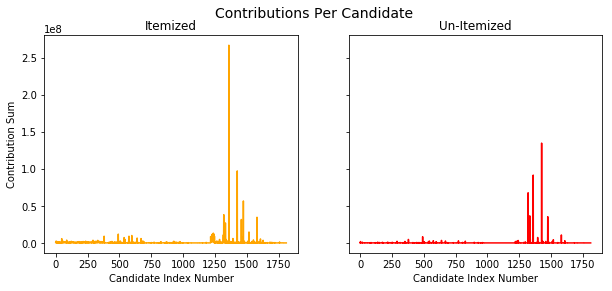

In [80]:
fig, ax = plt.subplots(1,2, figsize = (10,4), sharey= True)
ax[0].plot(money["ind_ite_con"], color = "orange")
ax[1].plot(money["ind_uni_con"], color = "red")


fig.suptitle("Contributions Per Candidate", fontsize = 14)
ax[0].set_title("Itemized")
ax[1].set_title("Un-Itemized")
ax[0].set_ylabel("Contribution Sum")
ax[0].set_xlabel("Candidate Index Number")
ax[1].set_xlabel("Candidate Index Number");

It looks like the same individuals got the most itemized and un-itemized contributions. The correlation below shows that those two categories strongly overlap.

In [56]:
money[["ind_ite_con", "ind_uni_con"]].corr()

,ind_ite_con,ind_uni_con
ind_ite_con,1.000000,0.791722
ind_uni_con,0.791722,1.000000


We follow up by looking at party committee contribution and other committee contributions. 

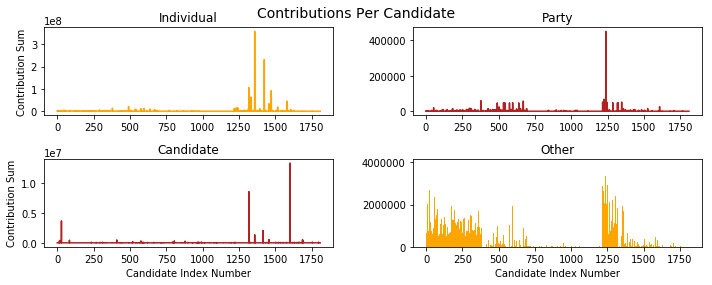

In [77]:
fig, ax = plt.subplots(2,2, figsize = (10,4))
ax[0, 0].plot(money["ind_con"], color = "orange")
ax[1, 0].plot(money["can_con"], color = "firebrick")
ax[0, 1].plot(money["par_com_con"], color = "firebrick")
ax[1, 1].bar(money.index, money["oth_com_con"], color = "orange", width = 4) #using bars because the plot was hard to read

fig.suptitle("Contributions Per Candidate", fontsize = 14)
ax[0, 0].set_title("Individual")
ax[1, 0].set_title("Candidate")
ax[0, 1].set_title("Party")
ax[1, 1].set_title("Other")
ax[0, 0].set_ylabel("Contribution Sum")
ax[1, 0].set_ylabel("Contribution Sum")
ax[1, 0].set_xlabel("Candidate Index Number")
ax[1, 1].set_xlabel("Candidate Index Number")

fig.tight_layout(w_pad=2.5) ;

The correlation between spending categories appears to be much smaller in this instance. The correlation matrix below confirms this finding.

In [78]:
money[["ind_con", "can_con", "par_com_con", "oth_com_con"]].corr()

,ind_con,can_con,par_com_con,oth_com_con
ind_con,1.000000,0.180615,0.067529,0.123264
can_con,0.180615,1.000000,0.000734,-0.015427
par_com_con,0.067529,0.000734,1.000000,0.286624
oth_com_con,0.123264,-0.015427,0.286624,1.000000


The *size* of average contributions is also dramatically different. 

In [423]:
money[["ind_con", "can_con", "par_com_con", "oth_com_con"]].mean()

ind_con        1.051990e+06
can_con        2.208759e+04
par_com_con    1.505788e+03
oth_com_con    2.294036e+05
dtype: float64

Individual contributions are, by far, the largest source of funding for candidates, followed by other committees (e.g. PACs), candidate contributions and political parties.

Even though the contributions of political parties is small, we might expect differences in contribution composition for candidates of different political parties. The table below shows the average contributions for the four previous categories and total contributions, broken down by party:

In [84]:
money.groupby("party")[["ind_con", "can_con", "par_com_con", "oth_com_con",  "tot_con"]].mean().round(2).sort_values(by = "tot_con", ascending = False)

,ind_con,can_con,par_com_con,oth_com_con,tot_con
party,,,,,
DEM,1480505.33,28457.25,1665.52,233486.03,1745333.77
REP,937422.28,21382.70,1710.11,277520.36,1237805.40
IND,115433.89,4132.57,158.36,21616.53,141417.16


For all three groups, individual contributions represent the bulk of the total contributions received. Candidate contributions are approximately twice the size of party contributions for Republicans and Democrats. Democrats have the highest (average) individual, candidate and total contributions -- Republicans have slightly higher party committee contributions and higher other committee contributions. Independents are outspent in total contributions by at least a factor of 9.

We now look at the same statistic by state.

In [268]:
money.groupby("can_off_sta")[["ind_con", "can_con", "par_com_con", "oth_com_con", "tot_con"]].mean().round(2).sort_values(by = "tot_con", 
                                                                                                           ascending = False).head(6)

,ind_con,can_con,par_com_con,oth_com_con,tot_con
can_off_sta,,,,,
US,6468183.49,69201.50,121.11,21229.34,6558687.42
MT,3177398.15,0.00,9284.82,480995.19,3667678.16
NH,1963915.39,5927.41,7757.26,430384.05,2407984.10
WI,1594026.45,2210.42,5935.04,330835.52,1933332.14
SD,935969.06,237.50,187.50,857678.84,1794072.90
VT,911901.61,8521.67,0.00,647483.55,1597172.83


Montana, New Hampshire, Wisconsin and South Dakota all have the highest average total contributions. The state-by-state breakdown shows significant differences in average spending composition: candidates from Nevada have an average of individual contributions higher by 123,869 dollars than that of Utah candidates, but the average total contributions are higher in Utah.

We can further illustrate those differences by looking at the weight of other committee spending per state.

In [176]:
money.groupby("can_off_sta")[["oth_com_con_per"]].mean().sort_values(by = "oth_com_con_per", ascending = False).head(3)

,oth_com_con_per
can_off_sta,
OH,inf
DC,0.665732
NE,0.398844


In [177]:
money.groupby("can_off_sta")[["oth_com_con_per"]].mean().sort_values(by = "oth_com_con_per", ascending = False).tail(3)

,oth_com_con_per
can_off_sta,
WY,0.026416
PR,0.009002
US,0.001613


Finally, we can look at differences in campaign funding for different offices.

In [112]:
money.groupby("can_off")[["ind_con", "can_con", "par_com_con", "oth_com_con",  "tot_con"]].mean().round(2).sort_values(by = "tot_con", ascending = False)

,ind_con,can_con,par_com_con,oth_com_con,tot_con
can_off,,,,,
P,6468183.49,69201.50,121.11,21229.34,6558687.42
S,1677855.62,8873.93,7471.49,380591.98,2077530.13
H,353178.03,18963.75,714.29,228508.67,601414.66


Presidential elections have, by far, the highest total contributions, which isn't surprising considering they are run at a much larger scale. Senate campaigns has overall higher contributions, except for candidate contributions. The same reasoning holds (House campaigns are more local, so require lower funding -- and candidates are more likely to fund themselves).

#### Campaign Duration

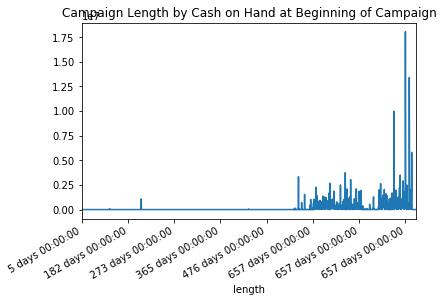

In [110]:
money.sort_values("length").plot("length","cas_on_han_beg_of_per", title = "Campaign Length by Cash on Hand at Beginning of Campaign", legend = False);

The graph above suggests that the candidates that have the most cash on hand at the *beginning* of the campaign are able to run longer. This may suggest that cash on hand may be a good predictor of success: it is observed early on in the campaign process and seems significantly correlated with, at least, the ability of a candidate to run the distance...

### Predicting Wins

........ Again, we start our exploration visually, with wins by contribution amounts.

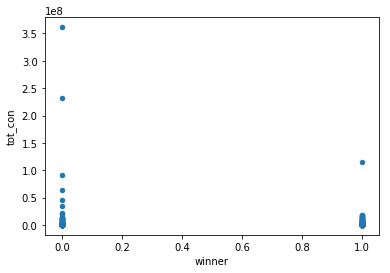

In [271]:
money.plot("winner", "tot_con",kind = "scatter");

The relationship seems to be *negative*: candidates with higher total contributions are more likely to lose. However, it could be that the candidates who attract higher contributions are running in more competitive races; thus, their likelihood of winning is lower.

In [280]:
con_quantiles = money['tot_con'].quantile([0.25, 0.5, 0.65, 0.75, 0.85, 0.95])
money.pivot_table('winner', index='can_inc_cha_ope_sea', columns= pd.cut(money['tot_con'], list(con_quantiles)), fill_value= 0)["CHALLENGER":]

tot_con,"(9368.5, 90556.66]","(90556.66, 450618.05]","(450618.05, 930000.185]","(930000.185, 1459406.16]","(1459406.16, 3315223.76]"
can_inc_cha_ope_sea,,,,,
CHALLENGER,0,0.012579,0.071429,0.250000,0.083333
INCUMBENT,0,0.800000,0.990291,0.976744,0.945736
OPEN,0,0.010309,0.320000,0.392857,0.464286


It is immediately obvious that incumbents have a **massive** advantage when it comes to re-election. Non-incumbents in open races have (obviously) a much higher chance of winning. Incumbents have the networks necessary to easily out-fund their adversaries. They are also a less risky bet for contributors than challengers.

Though nice, the pivot table does not tell us what the odds of success are for, say, a challenger with 800,000 in total contributions against an incumbent with only 100,000, or what the odds of them having those exact amounts are.

#### First Regression: Chance of Winning for an Individual Candidate given their individual characteristics

What do we know from the above? There isn't necessarily a relationship between total contributions and winning; political parties matter when it comes to raising money and winning; candidates with more cash-on-hand at the beginning of the campaign last longer; and incumbents have a considerable advantage when it comes to winning elections.

We want to put all of the above together to run a logit regression of the probability of winning for a candidate for a number of given characteristics.

##### Variable Selection

First we need to filter through all of our variables to find the ones best suited for the regression. Many of our variables have overlap, so we want to make sure we don't introduce multicollinearity in our model.

In [234]:
money.corr()["winner"][money.corr()["winner"] > abs(0.5)]

oth_com_con        0.676866
winner             1.000000
oth_com_con_per    0.821855
Name: winner, dtype: float64

Our dependent variable, winner, is highly correlated with `oth_com_con` and `oth_com_con_per`. Those two variables are the same thing, so we'll only use one. 

In [235]:
money.corr()["oth_com_con_per"][money.corr()["oth_com_con_per"] > abs(0.5)]

oth_com_con        0.655578
winner             0.821855
oth_com_con_per    1.000000
Name: oth_com_con_per, dtype: float64

In [237]:
money.corr()["oth_com_con"][money.corr()["oth_com_con"] > abs(0.5)]

oth_com_con        1.000000
winner             0.676866
oth_com_con_per    0.655578
Name: oth_com_con, dtype: float64

They are not strongly correlated to anything other than themselves.

 We were also interested in total contributions. As shown below, total contributions are **highly** correlated to a number of other variables -- including `cas_on_han_clo_of_per` and `net_ope_exp`. Therefore, as a general rule, we'll only use one of those at a time.

In [238]:
money.corr()["tot_con"][money.corr()["tot_con"] > abs(0.5)]

ind_ite_con              0.968574
ind_uni_con              0.915081
ind_con                  0.998510
tot_con                  1.000000
tot_rec                  0.976250
ope_exp                  0.976642
tot_dis                  0.978636
cas_on_han_clo_of_per    0.791032
net_con                  0.973802
net_ope_exp              0.982931
Name: tot_con, dtype: float64

Three of the other independent variables we were interested in, 'can_off', 'can_inc_cha_ope_sea', and 'party', are not numerical and so excluded from `.corr()`. We convert them into dummies below and check their correlation.

In [242]:
office = pd.get_dummies(money["can_off"], prefix='office')
pol_party = pd.get_dummies(money['party'], prefix='party')
status = pd.get_dummies(money['can_inc_cha_ope_sea'], prefix='status')
money_wdummies = money.join(office).join(pol_party).join(status)

In [260]:
money_wdummies.corr()["winner"][money_wdummies.corr()["winner"] > abs(0.5)]

oth_com_con         0.676866
winner              1.000000
oth_com_con_per     0.821855
status_INCUMBENT    0.877584
Name: winner, dtype: float64

The winner column is now *strongly* related to *both* `oth_com_con` and `status_INCUMBENT`. The code below shows that there is a strong correlation between `oth_com_con` and `status_INCUMBENT` -- i.e. oth_com_con could be correlated to winning because incumbents are more likely to win, thus get more contributions *or* incumbents could win because they get more contributions.

In [259]:
money_wdummies.corr()["status_INCUMBENT"][money_wdummies.corr()["status_INCUMBENT"] > abs(0.5)]

oth_com_con         0.707630
winner              0.877584
oth_com_con_per     0.852313
status_INCUMBENT    1.000000
Name: status_INCUMBENT, dtype: float64

There is also, as expected, a strong negative correlation between the different types of dummies (e.g. `party_DEM` and `party_REP`, Open races vs contested races, etc).

Therefore we will be using ** `oth_com_con`/`oth_com_con_per`, `tot_con`**, our **'status'**, and **party** dummies as independent variables.

##### First Regression

We can use what we have learned above to run a first logit regression on our DataFrame. This regression tries to estimate the factors of a success for an *individual* candidate for the Senated and House separately.

In [179]:
house = money[money["can_off"] == "H"]
senate = money[money["can_off"] == "S"]

In [261]:
reg_columns = ["winner", "oth_com_con", "tot_con"]
reg_data_house = house[reg_columns]
pol_party = pd.get_dummies(house['party'], prefix='party')
status = pd.get_dummies(house['can_inc_cha_ope_sea'], prefix='status')

reg_data_house = reg_data_house.join(pol_party.ix[:, 1:]).join(status.ix[:, 1:]) #exclude one of the dummy columns to avoid dummy var trap

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [262]:
ind_var = reg_data_house.columns[(reg_data_house.columns != "winner")]

logit = sm.Logit(reg_data_house['winner'], reg_data_house[ind_var])
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.326787
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 winner   No. Observations:                 1427
Model:                          Logit   Df Residuals:                     1421
Method:                           MLE   Df Model:                            5
Date:                Tue, 27 Mar 2018   Pseudo R-squ.:                  0.4686
Time:                        12:26:43   Log-Likelihood:                -466.33
converged:                       True   LL-Null:                       -877.47
                                        LLR p-value:                1.742e-175
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
oth_com_con       3.619e-06   8.73e-07      4.147      0.000    1.91e-06    5.33e-06
tot_con          -4.665e-07   1.84e-07     -2.538      0.011   -8.27e-07   -1.06e-07
party_IND           -4.8022      0.897     -5.356      0.000      -6.559      -3.045
party_REP           -2.4460      0.183    -13.382      0.000      -2.804      -2.088
status_INCUMBENT     3.6265      0.412      8.809      0.000       2.820       4.433
status_OPEN         -0.8990      0.197     -4.569      0.000      -1.285      -0.513
====================================================================================
"""

The regression shows that `oth_com_con` has a significant effect on re-election chances (though the coefficient may seem low, these campaign contributions often range in the hundred thousands) Democrats are the most likely to be re-elected, Independents the least. Finally, incumbents are shown to have a significant advantage over challengers. The negative coefficient of `tot_con` seems strange -- it might be that PACs indicate support from a more valuable constituency.

Previous iterations of this regression included operating expenditures and cash-on-hand at the beginning of the period, but both were found insignificant and were removed from the model without significantly altering its main results. 

This second model runs the same regression on Senate candidates.

In [267]:
reg_columns = ["winner", "tot_con", "oth_com_con"]
reg_data_senate = senate[reg_columns]
pol_party = pd.get_dummies(senate['party'], prefix='party')
status = pd.get_dummies(senate['can_inc_cha_ope_sea'], prefix='status')
reg_data_senate = reg_data_senate.join(pol_party.ix[:, 1:]).join(status.ix[:, 1:])
ind_var = reg_data_senate.columns[(reg_data_senate.columns != "winner")]
logit = sm.Logit(reg_data_senate['winner'], reg_data_senate[ind_var])
result = logit.fit()
result.summary()

         Current function value: 0.284433
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 winner   No. Observations:                  226
Model:                          Logit   Df Residuals:                      220
Method:                           MLE   Df Model:                            5
Date:                Tue, 27 Mar 2018   Pseudo R-squ.:                  0.3402
Time:                        12:34:48   Log-Likelihood:                -64.282
converged:                      False   LL-Null:                       -97.420
                                        LLR p-value:                 6.093e-13
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
tot_con          -8.537e-08   8.35e-08     -1.022      0.307   -2.49e-07    7.84e-08
oth_com_con       8.315e-07   8.77e-07      0.948      0.343   -8.87e-07    2.55e-06
party_IND          -22.9979   1.61e+04     -0.001      0.999   -3.16e+04    3.15e+04
party_REP           -3.4274      0.728     -4.709      0.000      -4.854      -2.001
status_INCUMBENT     4.6587      1.578      2.951      0.003       1.565       7.752
status_OPEN         -0.8749      0.500     -1.750      0.080      -1.855       0.105
====================================================================================

Possibly complete quasi-separation: A fraction 0.19 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Total contributions, other committee contributions and being an independent are insignificant for Senate candidates, their effect is close to zero. We might want to change some of our independent variables to better fit the model.

### Findings

- the exact *type* of contribution doesn't seem to matter as much as the overall level -- with the exception of **other committees** (e.g. PACs) for House races
- the composition of campaign finance varies accross type of race & state
- incumbents have a significant advantage when it comes to funding and re-election -- could be self-selection -- e.g. strong candidates avoid facing incumbents 
- *nevertheless* the size of spending (possibly spending ratio) matters
- all else equal, Democrats are more likely to be re-elected

### Next Steps?

A more precise model of winning-through-campaign finance might look at the expenses of several candidates at the same time (e.g. incumbent vs main challenger or two main candidates for open races).

A more precise model of win prediction would add information on general economic conditions, state or district characteristics (e.g. demographics, income, ...), and account for candidate-specific charactics (e.g. polls, likability, etc).